src: [Coding a Transformer from scratch on PyTorch, with full explanation, training and inference.
](https://www.youtube.com/watch?v=ISNdQcPhsts) by Umar Jamil.

I've made some modifications as I worked though it, for example, using pytorch lightning to organise the training and validation logic.


## attention is all you need

<p align="center">
    <img src="./images/transformer.png" alt="transformer architecture" width="400"/>
</p>


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Model blocks


In [2]:
class InputEmbedding(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        # the embedding dimension, called d_model in the attention is all you need paper.
        self.d_model = d_model
        self.vocab_size = vocab_size
        # nn.Embedding maps indices (here, indices of words in the vocabulary) to the same
        # tensor (a key-value lookup). The embeddings themselves are learnt as part of the model training.
        # num_embeddings is same as vocab size, as an embedding is learnt for each item in the vocabulary
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

    def forward(self, indices):
        return self.emb(indices) * np.sqrt(self.d_model)


indices = torch.tensor([1, 123, 678, 21, 90])
ie = InputEmbedding(512, 10_000)
probs = ie(indices)
print(indices.shape)
print(probs.shape)

torch.Size([5])
torch.Size([5, 512])


In [3]:
d = nn.Dropout(0.3)
# will zero ~3 elements at random. Used for regularisation during training
t = torch.rand(10)
d(t)

tensor([0.1305, 0.9885, 0.0000, 0.0000, 0.0000, 0.8463, 0.9005, 0.8272, 1.1029,
        0.4151])

In [4]:
1e4

10000.0

In [5]:
class PositionalEncoding(nn.Module):
    """this is only defined once and used during training and inference"""

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        # maximum sequence length you expect to see, so that we can generate positional encodings
        # upto that length
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # the positional encoding will be same dimension as the embedding for the sequence
        self.pe = torch.zeros(seq_len, d_model)
        self.set_positional_encoding()

    def set_positional_encoding(self):
        """Positional encoding, as described in the paper: attention is all you need.
        These can be predefined or learned, but the authors found no difference and chose this
        as it would allow it to generalize over sequence lengths greater than ones seen during training.
        """
        # pos from the paper
        position = torch.arange(0, self.seq_len, 1, dtype=torch.float).unsqueeze(1)
        # 2i from the paper: i is the dimension, here we operate on the even dimensions for both sin and cos
        # we apply the sin'd and cos'd sequences to even and odd dimensions respectively
        i_2 = torch.arange(0, self.d_model, 2)
        # numerically stable way of computing 1/((10_000)^(2i/d_model)) from the paper
        denominator = torch.exp((i_2 / self.d_model) * np.log(1e4))
        # across all seq, just even,odd dimensions
        self.pe[:, 0::2] = torch.sin(position / denominator)
        self.pe[:, 1::2] = torch.cos(position / denominator)
        # add batch dimension at start
        # pe is (1,seq_len, d_model)
        self.pe = self.pe.unsqueeze(0)
        # # a buffer is part of a module's state (state_dict) when saved, but is not a parameter that is
        # # tuned.
        # self.register_buffer("pe", self.pe)

    def forward(self, x):
        # x has a batch dimension
        # x shape is (batch, seq_len, d_model)
        # we add only the pe corresponding to x's sequence length
        if self.pe.device != x.device:
            self.pe = self.pe.to(x.device)
        x += (self.pe[:, : x.shape[1], :]).requires_grad_(False)
        # apply dropout
        x = self.dropout(x)
        return x


indices = torch.tensor([1, 123, 678, 21, 90]).unsqueeze(0)  # with batch dim
ie = InputEmbedding(512, 10_000)
max_seq_len = 1000
pe = PositionalEncoding(512, max_seq_len, 0.3)


probs = ie(indices)
print(indices.shape)
print(probs.shape)
out_pe = pe(probs)
print(out_pe.shape)

torch.Size([1, 5])
torch.Size([1, 5, 512])
torch.Size([1, 5, 512])


In [6]:
# In batchnorm, we calculate the mean, std dev across the batch dimension, ie, statistics
# across the batch, one per feature. after normalisation, we do an affine transform
# (m,b from y=mx+b), and m,b are learnable. this is so that it doesnt necessarily stick to zero mean
# and unit variance (which would limit model expressivity).
# But batchnorm will get representative mean,var only if batch size is a good enough size. Layernorm
# is batch size independant, and the mean,var is calculated across all features, for each input example independantly,
# and also applied to that input example alone independantly. It's used in transformers, rnn, etc
# where batch sizes may vary. see https://arxiv.org/abs/1607.06450
# note this has nothing to do with neural netowork layers, just the way it's applied to the data within the network
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-7) -> None:
        super().__init__()
        self.eps = eps
        self.m = nn.Parameter(torch.tensor([1.0]))
        self.c = nn.Parameter(torch.tensor([1.0]))

    def forward(self, x):
        # stats along the feature dimension
        # can also do keepdim=True instead of collapsing along mean dimension and adding it later
        mu = torch.mean(x, dim=-1).unsqueeze(-1)
        std = torch.std(x, dim=-1).unsqueeze(-1)
        # again, the learnable params m and c allow not nonzero mean and non-unit variance
        return self.m * ((x - mu) / (std + self.eps)) + self.c


t = torch.rand(32, 100, 3)
ln = LayerNorm()
ln(t).shape

torch.Size([32, 100, 3])

In [7]:
class FFN(nn.Module):
    def __init__(self, d_model, n_hidden, dropout: float) -> None:
        super().__init__()
        # self.d_model = d_model
        # self.n_hidden = n_hidden
        self.net = nn.Sequential(
            nn.Linear(d_model, n_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_hidden, d_model),
        )

    def forward(self, x):
        return self.net(x)


# batch,n,dim
# can give any number of examples (n)
# features is what each neuron operates on and learns a function of them, for the output.
t = torch.rand(32, 100, 512)
ffn = FFN(512, 2048, 0.3)
ffn(t).shape

torch.Size([32, 100, 512])

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float):
        super().__init__()
        # the embedding dimension will be split into n_heads equal chunks, with
        # each chunk (possibly) attending to it differently
        assert d_model % n_heads == 0
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.Wk = nn.Linear(d_model, d_model)
        self.Wq = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

    @staticmethod
    def attention(k, q, v, mask, dropout: nn.Dropout):
        d_k = q.shape[-1]
        # similarity (as a probability distribution) between what i have that is useful to other parts of me
        # , and what i need. Scale by root of the multi head attention dimension
        # shape is (batch, n_heads, seq_len, seq_len)
        similarities: torch.Tensor = (k @ q.transpose(-1, -2)) / np.sqrt(d_k)
        # mask_shape= (1, 1, seq_len, seq_len). make it a small value so softmax zeros it out
        if mask:
            # similarities[mask] = -torch.inf
            # NOTE this is an additive mask. we just set the appropriate locations to -inf, same as adding zero everywhere else and -inf/small value in parts we want to hide
            similarities.masked_fill_(mask == 0, -torch.inf)
        similarities_probability = F.softmax(similarities, dim=-1)
        if dropout:
            similarities_probability = dropout(similarities_probability)
        # gather appropriate values as a weighted(weights learnt) sum
        attention = similarities_probability @ v
        # similarities_probability used for visualisation
        return attention, similarities_probability

    def forward(self, k, q, v, mask):
        # for encoder, k,q,v all are input (x), but seperated it here because in the decoder, some might be form
        # the encoder and some might be from the decoder
        # x : (batch, seq_len, dim)
        # https://youtu.be/XfpMkf4rD6E?list=LL&t=1472
        # there are the (for me's) below as this is self attention
        k = self.Wk(k)  # what info do i have that is useful (for me)
        q = self.Wq(q)  # what info do i need (from me)?
        v = self.Wv(v)  # what info I publicly reveal (to other parts of me)?

        # split k,q,v along embedding dimension into h parts
        # we want (batch, head, seq, d_k) : each head should see the whole seq
        k = k.view(k.shape[0], k.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        q = q.view(q.shape[0], q.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(v.shape[0], v.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        mask = None
        # out has a shape batch, heads, seq_len, dk
        attention, self.similarity_prob = MultiHeadAttention.attention(
            k, q, v, mask, self.dropout
        )
        # view requires the tensor to be in continuous memory, which transpose disturbs, so we make it contiguous after transpose
        attention = (
            attention.transpose(1, 2).contiguous().view(k.shape[0], -1, self.d_model)
        )
        output = self.Wo(attention)
        return output


t = torch.rand(32, 100, 512)
mask = torch.ones(32, 1, 100)
mha = MultiHeadAttention(512, 4, 0.3)
# k,q,v all form the same input
mha(t, t, t, mask).shape

torch.Size([32, 100, 512])

In [9]:
l = nn.Linear(512, 512)
len(list(l.parameters())[1])

512

In [10]:
t = torch.rand(32, 4, 100, 128)

# q = torch.rand(512, 512)

(F.softmax((t @ t.transpose(-1, -2)), dim=1) @ (torch.rand(32, 4, 100, 128))).shape

torch.Size([32, 4, 100, 128])

In [11]:
class NormAndAdd(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm()

    def forward(self, x, prev_layer):
        # take the input to the previous layer, add it with the output of the previous layer (when fed in NORMALISED input)
        # this is different from the add&norm in the original paper, and is one of the few improvements to the original architecture.
        # the previous layer takes in normalised INPUT, not normalising the output. This prevents exploding gradients, etc and helps
        # in better training dynamics
        return self.dropout(prev_layer(self.norm(x))) + x

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, mha: MultiHeadAttention, ffn: FFN, dropout: float) -> None:
        super().__init__()
        self.mha = mha
        self.ffn = ffn
        # residual connections - two because they have seperate layernorms and layernorm parameters
        self.rc1 = NormAndAdd(dropout)
        self.rc2 = NormAndAdd(dropout)

    def forward(self, x, src_mask):
        out = self.rc1(x, lambda x: self.mha(x, x, x, src_mask))
        out = self.rc2(out, self.ffn)
        return out


t = torch.rand(32, 100, 512)
mask = torch.ones(32, 100, 100)
mha = MultiHeadAttention(512, 4, 0.3)
ffn = FFN(512, 2048, 0.3)
ecl = EncoderLayer(mha, ffn, 0.3)

ecl(t, mask).shape

torch.Size([32, 100, 512])

In [13]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNorm()

    def forward(self, x, src_mask):
        for layer in self.layers:
            x = self.norm(layer(x, src_mask))
        return x


t = torch.rand(32, 100, 512)
mask = torch.ones(32, 100, 100)


encoder = Encoder(
    nn.ModuleList(
        [
            EncoderLayer(MultiHeadAttention(512, 4, 0.3), FFN(512, 2048, 0.3), 0.3)
            for _ in range(10)
        ]
    )
)

encoder(t, mask).shape

torch.Size([32, 100, 512])

In [87]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        mmha: MultiHeadAttention,
        mha: MultiHeadAttention,
        ffn: FFN,
        dropout: float,
    ) -> None:
        super().__init__()
        # masked multi head attention also in this. this is the self attention
        self.mmha = mmha
        # will be cross attention, as k,q come from encoder
        self.mha = mha
        self.ffn = ffn
        self.rc1 = NormAndAdd(dropout)
        self.rc2 = NormAndAdd(dropout)
        self.rc3 = NormAndAdd(dropout)

    def forward(
        self,
        encoder_out,
        src_mask,
        trg,
        trg_mask,
    ):
        out = self.rc1(trg, lambda x: self.mmha(x, x, x, trg_mask))
        # query is from the decoder, the encoder answers
        out = self.rc2(out, lambda x: self.mha(encoder_out, x, encoder_out, src_mask))
        out = self.rc3(out, self.ffn)
        return out


class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNorm()

    def forward(
        self,
        encoder_out,
        src_mask,
        trg,
        trg_mask,
    ):
        for layer in self.layers:
            x = self.norm(layer(encoder_out, src_mask, trg, trg_mask))
        return x


encoder_out = torch.rand(32, 100, 512)
tout = torch.rand(32, 1, 512)
src_mask = torch.ones(32,1, 1, 100)
# src_mask = torch.ones(32,100, 100)
# trg_mask = torch.ones(32, 100, 100)
trg_mask = torch.ones(32, 1,100)


decoder = Decoder(
    nn.ModuleList(
        [
            DecoderLayer(
                MultiHeadAttention(512, 4, 0.3),
                MultiHeadAttention(512, 4, 0.3),
                FFN(512, 2048, 0.3),
                0.3,
            )
            for _ in range(10)
        ]
    )
)
decoder(encoder_out, src_mask, tout, trg_mask).shape

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [128, 1] but got: [128, 100].

In [15]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        # features will go from d_model to vocab_size
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # (batch,seq_len,d_model) -> (batch, seq_len, vocab_size)
        # we want a probability over all the positions in the vocabulary
        # return F.softmax(self.proj(x), dim=-1)
        # more numerically stable, can always exp later to get true non-log probabilities
        return F.log_softmax(self.proj(x), dim=-1)

In [61]:
class Transformer(nn.Module):
    def __init__(
        self,
        enc: Encoder,
        dec: Decoder,
        src_emb: InputEmbedding,
        trg_emb: InputEmbedding,
        src_pos: PositionalEncoding,
        trg_pos: PositionalEncoding,
        proj: ProjectionLayer,
    ):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.src_emb = src_emb
        self.trg_emb = trg_emb
        self.src_pos = src_pos
        self.trg_pos = trg_pos
        self.proj = proj

    def encode(self, src_indices, src_mask):
        # indices: (batch, indices(padded))
        x = self.src_emb(src_indices)
        x = self.src_pos(x)
        x = self.enc(x, src_mask)
        return x

    def decode(self, enc_out, src_mask, trg_indices, trg_mask):
        x = self.trg_emb(trg_indices)
        x = self.trg_pos(x)
        x = self.dec(enc_out, src_mask, x, trg_mask)
        return x
    def project(self,decoder_out):
        return self.proj(decoder_out)

    def forward(self, src_indices, src_mask, trg_indices, trg_mask):
        enc_out = self.encode(src_indices, src_mask)
        decoded = self.decode(enc_out, src_mask, trg_indices, trg_mask)
        probs = self.project(decoded)
        return probs

In [62]:
def build_transformer(
    src_vocab_size: int,
    trg_vocab_size: int,
    d_model: int,
    src_seq_len: int,
    trg_seq_len: int,
    encdec_layers: int,
    n_heads: int,
    dropout: float = 0.1,
    d_hh: int = 2048,
):
    # as an example, this is for a translation task.
    src_ie = InputEmbedding(d_model, src_vocab_size)
    trg_ie = InputEmbedding(d_model, trg_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    trg_pos = PositionalEncoding(d_model, trg_seq_len, dropout)

    encoder = Encoder(
        nn.ModuleList(
            [
                EncoderLayer(
                    MultiHeadAttention(d_model, n_heads, dropout),
                    FFN(d_model, d_hh, dropout),
                    dropout,
                )
                for _ in range(encdec_layers)
            ]
        )
    )
    decoder = Decoder(
        nn.ModuleList(
            [
                DecoderLayer(
                    MultiHeadAttention(d_model, n_heads, dropout),
                    MultiHeadAttention(d_model, n_heads, dropout),
                    FFN(d_model, d_hh, dropout),
                    dropout,
                )
                for _ in range(encdec_layers)
            ]
        )
    )
    proj = ProjectionLayer(d_model, trg_vocab_size)
    transformer = Transformer(encoder, decoder, src_ie, trg_ie, src_pos, trg_pos, proj)

    # xavier init
    for p in transformer.parameters():
        if p.dim() > 1:
            # in place op if ends with an underscore.
            nn.init.xavier_uniform_(p)
    return transformer

# Prepare dataset


In [18]:
# ! pip install datasets tokenizers

In [19]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

In [20]:
config = {
    # "tokenizer_path": "./data/",
    "translation": "en-fr",
    "tr_src": "en",
    "tr_tgt": "fr",
    "max_seq_len": 500,
    "batch_size": 16,
}

In [21]:
hf_dataset = load_dataset("opus_books", config["translation"], split="train")
hf_dataset

Dataset({
    features: ['id', 'translation'],
    num_rows: 127085
})

In [22]:
s = "hello my name is senor bean"
t = Tokenizer(WordLevel(unk_token="[UNK]"))
t.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(
    special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=1
)
# senor not in vocabulary
t.train_from_iterator(
    [
        [
            "hello i like bean",
            "ola",
            "my neck hurts",
            "is the earth round",
            "what is your name?",
        ]
    ],
    trainer=trainer,
)
print("unknown token id is", t.token_to_id("[UNK]"))
ids = t.encode(s).ids
print("original:", s)
print("encoded:", ids)
print("decoded:", t.decode(ids, skip_special_tokens=False))

unknown token id is 0
original: hello my name is senor bean
encoded: [8, 12, 13, 4, 0, 6]
decoded: hello my name is [UNK] bean


In [23]:
def get_sentences(ds, lang):
    for item in ds:
        # semantics based on how the dataset is organised
        yield item["translation"][lang]


def get_tokenizer(ds, lang):
    # i'll skip caching the tokenizer, it's not super expensive
    t = Tokenizer(WordLevel(unk_token="[UNK]"))
    t.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(
        special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2
    )
    # senor not in vocabulary
    t.train_from_iterator(get_sentences(ds, lang), trainer=trainer)
    return t


get_tokenizer(hf_dataset, config["tr_src"])

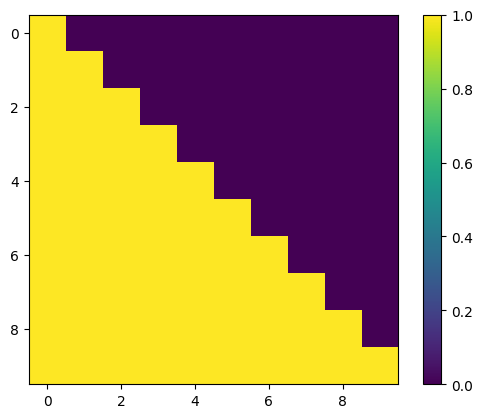

In [24]:
def causal_mask(size):
    # to ensure that in the encoder, the attention is applied only to the past values from the current token
    m = torch.ones(1, size, size)
    # only the lower triangle will be one
    return torch.tril(m).bool()


m = causal_mask(10).squeeze(0)
plt.imshow(m)
plt.colorbar()

In [25]:
class BiLingualDataset(Dataset):
    def __init__(
        self, hf_dataset, src_tokenizer, tgt_tokenizer, src_lang, tgt_lang, max_seq_len
    ) -> None:
        super().__init__()
        self.hf_dataset = hf_dataset
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_seq_len = max_seq_len

        self.pad_token_id = torch.tensor([src_tokenizer.token_to_id("[PAD]")]).int()
        self.sos_token_id = torch.tensor([src_tokenizer.token_to_id("[SOS]")]).int()
        self.eos_token_id = torch.tensor([src_tokenizer.token_to_id("[EOS]")]).int()

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx) -> dict:
        src_text = self.hf_dataset[idx]["translation"][self.src_lang]
        tgt_text = self.hf_dataset[idx]["translation"][self.tgt_lang]

        src_encoded = self.src_tokenizer.encode(src_text).ids
        tgt_encoded = self.src_tokenizer.encode(tgt_text).ids

        # src encoded (encoder input) will have [sos],[eos]
        src_padding_len = self.max_seq_len - (len(src_encoded) + 2)
        # target_encoded (the decoder input) will not have [eos], has [sos]
        # the label(decoder output) will not have [sos], but will have [eos]
        # this is because the label is the same as the decoder input shifted by one
        # (since this is next token prediction)
        tgt_padding_len = self.max_seq_len - (len(tgt_encoded) + 1)

        if (src_padding_len < 0) or (tgt_padding_len < 0):
            raise Exception("max_seq_len too small")

        encoder_inp = torch.cat(
            [
                self.sos_token_id,
                torch.tensor(src_encoded),
                self.eos_token_id,
                torch.tensor([self.pad_token_id for _ in range(src_padding_len)]),
            ]
        ).int()
        decoder_inp = torch.cat(
            [
                self.sos_token_id,
                torch.tensor(tgt_encoded),
                torch.tensor([self.pad_token_id for _ in range(tgt_padding_len)]),
            ]
        ).int()
        labels = torch.cat(
            [
                torch.tensor(tgt_encoded),
                self.eos_token_id,
                torch.tensor([self.pad_token_id for _ in range(tgt_padding_len)]),
            ]
        ).int()
        assert encoder_inp.shape[-1] == self.max_seq_len
        assert decoder_inp.shape[-1] == self.max_seq_len
        return {
            # (seq,)
            "encoder_in": encoder_inp,
            # (seq,)
            "decoder_in": decoder_inp,
            # (seq,)
            "labels": labels,
            # add batch dim, second sequence dim , (1,1,seq)
            "encoder_mask": (encoder_inp != self.pad_token_id)
            .unsqueeze(0)
            .unsqueeze(0)
            .int(),
            # (1,seq,seq)
            "decoder_mask": (decoder_inp != self.pad_token_id)
            .unsqueeze(0)
            .unsqueeze(0)
            .int()
            & causal_mask(decoder_inp.shape[0]),
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

In [26]:
src_tokenizer = get_tokenizer(hf_dataset, config["tr_src"])
tgt_tokenizer = get_tokenizer(hf_dataset, config["tr_tgt"])

In [27]:
max_src_len, max_tgt_len = 0, 0
for item in hf_dataset:
    # calculate maximum token lengths
    max_src_len = max(
        max_src_len,
        len(src_tokenizer.encode(item["translation"][config["tr_src"]]).ids),
    )
    max_tgt_len = max(
        max_tgt_len,
        len(tgt_tokenizer.encode(item["translation"][config["tr_tgt"]]).ids),
    )

# this will inform config['max_seq_len']
print(f"max src len: {max_src_len}")
print(f"max tgt len: {max_tgt_len}")

max src len: 471
max tgt len: 482


In [28]:
# just to test things
d = BiLingualDataset(
    hf_dataset,
    src_tokenizer,
    tgt_tokenizer,
    config["tr_src"],
    config["tr_tgt"],
    config["max_seq_len"],
)

probs = d[0]
print(probs["encoder_in"].shape)
print(probs["encoder_mask"].shape)
print(probs["decoder_in"].shape)
print(probs["decoder_mask"].shape)
print(probs["labels"].shape)

torch.Size([500])
torch.Size([1, 1, 500])
torch.Size([500])
torch.Size([1, 500, 500])
torch.Size([500])


In [101]:
train_size = int(0.9 * len(hf_dataset))
val_size = len(hf_dataset) - train_size

train_hf_ds, val_hf_ds = random_split(hf_dataset, [train_size, val_size])
train_ds = BiLingualDataset(
    train_hf_ds,
    src_tokenizer,
    tgt_tokenizer,
    config["tr_src"],
    config["tr_tgt"],
    config["max_seq_len"],
)
val_ds = BiLingualDataset(
    val_hf_ds,
    src_tokenizer,
    tgt_tokenizer,
    config["tr_src"],
    config["tr_tgt"],
    config["max_seq_len"],
)
train_loader = DataLoader(train_ds, config["batch_size"], shuffle=True)
# batch size one, as we dont want to average statistics across the batch for the validation step,
# at least at the experimentation stage.
val_loader = DataLoader(val_ds, 1, shuffle=False)

model = build_transformer(
    src_tokenizer.get_vocab_size(),
    tgt_tokenizer.get_vocab_size(),
    64,
    config["max_seq_len"],
    config["max_seq_len"],
    3,
    2,
)

# Training loop


In [91]:
import lightning as L
from lightning.pytorch.utilities.model_summary import ModelSummary
import torchmetrics

In [102]:
example_input = next(iter(train_loader))
example_input['encoder_in'].shape

torch.Size([16, 500])

In [103]:
# fastest way to define a device and parallelism agnostic training loop
class LightningLoop(L.LightningModule):
    def __init__(self, model: Transformer, example_input:dict):
        super().__init__()
        self.example_input_array = example_input
        self.model = model
        # contrary to how it sounds, ignore index actually takes in a _target_ VALUE to be ignored
        # label smoothing makes the model less overconfident in any one output, and distributes the probs to others - to prevent overfitting
        # take 0.1% of prob from highest prob and distribute among others
        self.loss_fn = nn.CrossEntropyLoss(
            ignore_index=src_tokenizer.token_to_id("[PAD]"), label_smoothing=0.1
        )
        self.acc = torchmetrics.Accuracy(task='multiclass', num_classes=tgt_tokenizer.get_vocab_size())

    def forward(self,**kwargs):
        print('in forward pass, just for calculating example shapes')
        # if example input array is a dict, passes as keywords to this function.
        # This is just for passing the example input through the layers
        batch = kwargs
        encoder_inp = batch["encoder_in"]
        decoder_inp = batch["decoder_in"]
        labels = batch["labels"]  # (batch,max_seq_len)
        encoder_mask = batch["encoder_mask"]
        decoder_mask = batch["decoder_mask"]
        out = self.model(encoder_inp, encoder_mask, decoder_inp, decoder_mask)
        out = out.view(-1, tgt_tokenizer.get_vocab_size())
        loss = self.loss(out, labels.view(-1).long())
        return loss

    def loss(self, input, target):
        return self.loss_fn(input, target)

    def training_step(self, batch):
        encoder_inp = batch["encoder_in"]
        decoder_inp = batch["decoder_in"]
        labels = batch["labels"]  # (batch,max_seq_len)
        encoder_mask = batch["encoder_mask"]
        decoder_mask = batch["decoder_mask"]
        # will have shape (batch, max_seq_len, tgt_vocab_size)
        out = self.model(encoder_inp, encoder_mask, decoder_inp, decoder_mask)
        # (batch, max_seq_len, tgt_vocab_size) -> (batch* max_seq_len, tgt_vocab_size)
        out = out.view(-1, tgt_tokenizer.get_vocab_size())
        # compare (batch* max_seq_len, tgt_vocab_size) with (batch* max_seq_len)
        # the crossentropyloss function can take in the input like this.
        loss = self.loss(out, labels.view(-1))
        self.log("Loss/train", loss, prog_bar=True)
        _, pred_ids = torch.max(out,dim=1)
        self.log("Accuracy/train", self.acc(pred_ids, labels.view(-1)), prog_bar=True)
        return loss

    def validation_step(self, batch):
        encoder_inp = batch["encoder_in"]
        decoder_inp = batch["decoder_in"]
        labels = batch["labels"]
        encoder_mask = batch["encoder_mask"]
        decoder_mask = batch["decoder_mask"]
        out = self.model(encoder_inp, encoder_mask, decoder_inp, decoder_mask)
        out = out.view(-1, tgt_tokenizer.get_vocab_size())
        loss = self.loss(out, labels.view(-1))
        self.log("Loss/val ", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# might have to move the model to cpu before running this
lightning_loop = LightningLoop(model, example_input)
ModelSummary(lightning_loop, max_depth=2)

in forward pass, just for calculating example shapes


  | Name          | Type               | Params | Mode  | In sizes                                                           | Out sizes       
-----------------------------------------------------------------------------------------------------------------------------------------------------
0 | model         | Transformer        | 7.5 M  | train | [[16, 500], [16, 1, 1, 500], [16, 500], [16, 1, 500, 500]]         | [16, 500, 30000]
1 | model.enc     | Encoder            | 842 K  | train | [[16, 500, 64], [16, 1, 1, 500]]                                   | [16, 500, 64]   
2 | model.dec     | Decoder            | 892 K  | train | [[16, 500, 64], [16, 1, 1, 500], [16, 500, 64], [16, 1, 500, 500]] | [16, 500, 64]   
3 | model.src_emb | InputEmbedding     | 1.9 M  | train | [16, 500]                                                          | [16, 500, 64]   
4 | model.trg_emb | InputEmbedding     | 1.9 M  | train | [16, 500]                                                          | [16

In [99]:
_,ids = torch.max(torch.rand(500,3000),dim=1)
ids.shape

torch.Size([500])

In [ ]:
# overfit on a single batch as a test
trainer = L.Trainer(max_epochs=1000, log_every_n_steps=10,limit_train_batches=1)
# trainer.fit(lightning_loop, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.fit(lightning_loop, train_dataloaders=train_loader)

In [90]:
def greedy_search(model:Transformer, src_indices,src_mask, src_text,trg_text):
    start_token_idx = src_tokenizer.token_to_id('[SOS]')
    end_token_idx = src_tokenizer.token_to_id('[EOS]')
    encoder_out = model.encode(src_indices,src_mask)
    print(encoder_out.shape)
    print(src_mask.shape)
    decoder_inp = torch.empty(1,1).fill_(start_token_idx).type_as(src_indices)

    while True:
        if decoder_inp.shape[-1]>config['max_seq_len']:
            break
        print(model.trg_emb(decoder_inp).shape)
        decoder_mask = causal_mask(decoder_inp.shape[-1])
        print(decoder_mask.shape)
        decode_out = model.decode(
            encoder_out, src_mask, decoder_inp, decoder_mask
        )
        # probs for the last token
        probs = model.proj(decode_out[-1,:])
        _,next_word_idx = torch.max(probs, dim=1)
        decoder_inp = torch.cat([decoder_inp, torch.empty(1,1).fill_(next_word_idx).type_as(src_indices)])
        if next_word_idx==end_token_idx:
            break
        print('ok')
    pred_sentence = tgt_tokenizer.decode(decoder_inp.flatten(), skip_special_tokens=False)
    print('src:', src_text)
    print('tgt:', trg_text)
    print('pred:', pred_sentence)

# TODO!!!!!
# model = model.cpu()
# example_input=next(iter(val_loader))
# greedy_search(model, example_input['encoder_in'], example_input['encoder_mask'],example_input['src_text'],example_input['tgt_text'])



In [105]:
# this expects the encoding to already be done
model_pt = nn.Transformer(
    d_model=64,
    nhead=2,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.1,
    batch_first=True,
    norm_first=True
)
model_pt(
    example_input['encoder_in'],
    example_input['decoder_in'],
    example_input['encoder_mask'],
    example_input['decoder_mask'],
)

/Users/rohan/miniconda3/envs/coral-agent/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: the feature number of src and tgt must be equal to d_model

: 